Author Type Classification
===

Notebook to build models for the author type classification.

The problem can be thought of in multiple ways, but here it is modeled as a binary problem of separating patient-authored posts from posts authored by anyone else.

(A general three-class model could include Patient, Caregiver, and Other/Unknown.  A fourth plausible class is "P/CG".)

Current classification approach uses Vowpal Wabbit. Future approaches could try using sklearn or more sophisticated approaches if necessary.  (One could for example use PyStruct i.e. a structured prediction model that uses context to assign author labels.)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

from collections import Counter
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
import sys
sys.path.append("/home/srivbane/levon003/repos/qual-health-journeys/annotation_data")
import journal as journal_utils

In [4]:
general_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
vw_working_dir = os.path.join(general_working_dir, "vw")
os.makedirs(vw_working_dir, exist_ok=True)

In [5]:
use_cached_results = False  # set to true to load cached intermediate results from pickle rather than redoing the computations

# Caching option specifically for instrumental support, since that's more intensive computationally
use_cached_instrumental_support_results = True

In [6]:
def get_db():
    journal_wd="/home/srivbane/shared/caringbridge/data/projects/caringbridge_core"
    db_filename = os.path.join(journal_wd, "journal_cleaned.sqlite")
    db = sqlite3.connect(
            db_filename,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
    db.row_factory = sqlite3.Row
    return db


def get_journal_text(site_id, journal_oid):
    site_id = int(site_id)
    
    # add journal text as new section
    try:
        db = get_db()
        cursor = db.execute("""SELECT body
                                FROM journalTextCleaned 
                                WHERE site_id = ? AND journal_oid = ?""", 
                            (site_id, journal_oid))
        body = cursor.fetchone()
        assert body is not None
        body_text = process_body_text(body['body'])
        return body_text
    finally:
        db.close()
        
def get_journal_texts(site_id):
    site_id = int(site_id)
    
    texts = []
    try:
        db = get_db()
        cursor = db.execute("""SELECT journal_oid, body
                                FROM journalTextCleaned 
                                WHERE site_id = ?""", 
                            (site_id,))
        results = cursor.fetchall()
        assert results is not None
        for result in results:
            body_text = process_body_text(result['body'])
            journal_oid = result['journal_oid']
            texts.append({
                'journal_oid': journal_oid,
                'body': body_text
            })
        return texts
    finally:
        db.close()
        

DUMMY_JOURNAL1 = "This CaringBridge site was created just recently."
        
def process_body_text(body_text):  # excludes invalid body texts, converting them to the empty string
    if body_text is None:
        body_text = ""
    elif body_text.startswith(DUMMY_JOURNAL1):
        body_text = ""
    return body_text

In [7]:
def get_cleaned_text_from_token_list(token_list):
    cleaned_text = " ".join(token_list).replace(':', 'COLON').replace('|', 'PIPE').replace("\n", "NEWLINE ")
    return cleaned_text

def get_cleaned_text(text, lowercase=True):
    tokens = text.split()
    if lowercase:
        tokens = [token.lower() for token in tokens]
    cleaned_text = get_cleaned_text_from_token_list(tokens)
    return cleaned_text

### Load annotation client author types

In [23]:
annotation_web_client_database = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/instance/cbAnnotator.sqlite"


def get_annotation_db():
    db = sqlite3.connect(
            annotation_web_client_database,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
    db.row_factory = sqlite3.Row
    return db


def get_author_annotations():
    try:
        db = get_annotation_db()
        cursor = db.execute(
            """SELECT site_id, journal_oid, username, data 
                FROM journalAnnotation
                WHERE annotation_type = "journal_author_type"
                GROUP BY site_id, journal_oid, username
                ORDER BY id DESC""")
        journal_author_annotations = cursor.fetchall()
        annotation_strings = [{'site_id': a['site_id'], 
                               'journal_oid': a['journal_oid'], 
                               'username': a['username'],
                               'data': a['data']}
                              for a in journal_author_annotations if a['journal_oid'] != 'site']
        return annotation_strings
    finally:
        db.close()


# Test extraction of annotations
get_author_annotations()[:5]

[{'site_id': 382634,
  'journal_oid': '51be46bf6ca004dd590026c5',
  'username': 'levon003',
  'data': 'p'},
 {'site_id': 260918,
  'journal_oid': '51be39326ca004972c004e43',
  'username': 'levon003',
  'data': 'unk'},
 {'site_id': 902822,
  'journal_oid': '54198aa2af3d79da10de22ce',
  'username': 'levon003',
  'data': 'p'},
 {'site_id': 902822,
  'journal_oid': '54198a60ac7ee94e4120da68',
  'username': 'levon003',
  'data': 'unk'},
 {'site_id': 902822,
  'journal_oid': '54f0e0fbf0206519299f25ec',
  'username': 'levon003',
  'data': 'p'}]

In [24]:
web_client_annotations_raw = get_author_annotations()
Counter([a['data'] for a in web_client_annotations_raw]).most_common()

[('p', 6482), ('cg', 1418), ('unk', 85), ('pcg', 18)]

In [25]:
df = pd.DataFrame(web_client_annotations_raw)

skip_count = 0
arbitrary_selection_count = 0
levon003_preferred_selection_count = 0

conflict_resolved_author_type_annotations = []
for key, group in df.groupby(by=['site_id', 'journal_oid'], sort=False):
    if len(group) == 1:
        row = group.iloc[0]
        entry = {'site_id': row['site_id'], 
           'journal_oid': row['journal_oid'], 
           'data': row['data']}
        conflict_resolved_author_type_annotations.append(entry)
    else:
        assert len(group) > 1
        group_data = set(group.data)
        if len(group_data) == 1:
            # multiple annotators, but they all agree
            row = group.iloc[0]
            entry = {'site_id': row['site_id'], 
               'journal_oid': row['journal_oid'], 
               'data': row['data']}
            conflict_resolved_author_type_annotations.append(entry)
        else:
            # multiple annotators, and there is some disagreement
            data, count = Counter(group_data).most_common()[0]
            data = str(data)
            assert "memory" not in data
            if count == 1:
                if "p" in group_data and "cg" in group_data:
                    # we ignore obviously confused situations
                    skip_count += 1
                    continue
                if "levon003" in set(group.username):
                    # prefer levon003's annotations...
                    levon003_preferred_selection_count += 1
                    data = str(group[group.username == 'levon003'].iloc[0]['data'])
                else:  # make an arbitrary choice
                    arbitrary_selection_count += 1
                    site_id = group.iloc[0].site_id
                    journal_oid = group.iloc[0].journal_oid
                    print(f"127.0.0.1:5000/siteId/{site_id}#{journal_oid}")
            row = group.iloc[0]
            entry = {'site_id': row['site_id'], 
               'journal_oid': row['journal_oid'], 
               'data': data}
            conflict_resolved_author_type_annotations.append(entry)
print(f"Made {arbitrary_selection_count} arbitrary selections in situations of conflict.")
print(f"Preferred levon003's annotations in {levon003_preferred_selection_count} situations of conflict.")
print(f"Skipped {skip_count} obviously confused situations.")
len(conflict_resolved_author_type_annotations)

Made 0 arbitrary selections in situations of conflict.
Preferred levon003's annotations in 26 situations of conflict.
Skipped 11 obviously confused situations.


7013

In [26]:
Counter([t['data'] for t in conflict_resolved_author_type_annotations]).most_common()

[('p', 5979), ('cg', 959), ('unk', 69), ('pcg', 6)]

In [27]:
# agreement analysis
from collections import defaultdict

df = pd.DataFrame(web_client_annotations_raw)

levon003 = []
luoxx498 = []  # NOTE: the actual username is set by luoxx498_un
luoxx498_un = "mill6273"  # Hannah Miller Hillberg

num_annotators = []
annotation_list = []
annotator_counts = defaultdict(int)
for key, group in df.groupby(by=['site_id', 'journal_oid'], sort=False):
    if len(group) == 1:
        continue
    else:  # this journal has multiple annotators
        annotations = [1 if data == 'p' else 0 for data in group.data]
        total_p = sum(annotations)
        total_not_p = len(annotations) - total_p
        annotation_list.append((total_p, total_not_p))
        assert len(set(group.username)) == len(group)
        num_annotators.append(len(group))
        for username, annotation in zip(group.username, annotations):
            annotator_counts[username] += 1
            
        usernames = set(group.username)
        
        if "levon003" in usernames and luoxx498_un in usernames:
            assert len(group[group.username == "levon003"]) == 1
            assert len(group[group.username == luoxx498_un]) == 1
            levon003.append(1 if group[group.username == "levon003"].iloc[0]['data'] == 'p' else 0)
            luoxx498.append(1 if group[group.username == luoxx498_un].iloc[0]['data'] == 'p' else 0)
annotator_counts

defaultdict(int,
            {'levon003': 573,
             'naray114': 193,
             'luoxx498': 235,
             'vachh007': 113,
             'rubya001': 177,
             'eriks074': 3,
             'mill6273': 429})

In [28]:
from sklearn.metrics import cohen_kappa_score
print(len(levon003), len(luoxx498))
levon003, luoxx498 = np.array(levon003), np.array(luoxx498)
print(np.sum(levon003 == luoxx498) / len(levon003))
cohen_kappa_score(levon003, luoxx498)

429 429
0.9906759906759907


0.8285714285714285

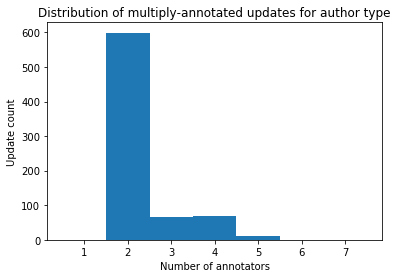

In [29]:
plt.hist(num_annotators, bins=range(1, 9), align='left')
plt.title("Distribution of multiply-annotated updates for author type")
plt.xlabel("Number of annotators")
plt.ylabel("Update count")
plt.show()

In [30]:
web_client_annotation_list = []

for annotation in tqdm(conflict_resolved_author_type_annotations):
    site_id = annotation['site_id']
    journal_oid = annotation['journal_oid']
    body = get_journal_text(site_id, journal_oid)
    if body is None or len(body) < 50:
        continue
        
    label = annotation['data']
    # One consideration: do we want to include unknown journals in the training data?
    #if label == "unk":
    #    continue
        
    cleaned_body = get_cleaned_text(body)
    
    annotation_dict = {
        "site_id": annotation['site_id'],
        "journal_oid": annotation['journal_oid'], 
        "cleaned_body": cleaned_body,
        "label": label
    }
    web_client_annotation_list.append(annotation_dict)

len(web_client_annotation_list)

100%|██████████| 7013/7013 [01:45<00:00, 66.23it/s] 


6932

In [31]:
web_client_annotation_list_pickle_filepath = os.path.join(vw_working_dir, "web_client_annotations.pkl")

if use_cached_results and os.path.exists(web_client_annotation_list_pickle_filepath):
    print("Loading from pickled file.")
    with open(web_client_annotation_list_pickle_filepath, 'rb') as f:
        web_client_annotation_list = pickle.load(f)
else:  # should save the processed list
    print("Saving to pickled file.")
    #df = pd.DataFrame(web_client_annotation_list)
    #df.to_pickle(web_client_annotation_list_pickle_filepath)
    with open(web_client_annotation_list_pickle_filepath, 'wb') as f:
        pickle.dump(web_client_annotation_list, f)
print("Finished.")

Saving to pickled file.
Finished.


In [ ]:
get_journal_text(28484, "51bdfaee6ca004ae6400f06c")

In [ ]:
web_client_annotation_list[0]

In [34]:
web_client_annotation_df = pd.DataFrame(web_client_annotation_list)
len(web_client_annotation_df)

6932

In [35]:
Counter(web_client_annotation_df['label']).most_common()

[('p', 5938), ('cg', 950), ('unk', 38), ('pcg', 6)]

### Load instrumental support coding author types

In [36]:
appreciation_coding_filepath = "/home/srivbane/levon003/repos/instrumental_support/appreciation_coding/collect_coding_results/certain_data/all_certain_data.csv"
df = pd.read_csv(appreciation_coding_filepath)
len(df)

732

In [37]:
Counter(df['author_type']).most_common()

[('C', 427), ('P', 292), ('PC', 13)]

In [38]:
instrumental_support_annotation_list = []
skipped = 0
if not use_cached_instrumental_support_results:
    try:
        db = get_db()
        for i in tqdm(range(len(df))):
            row = df.iloc[i]
            site_id = int(row['site_id'])

            if len(row['body_text']) < 50:
                continue
            comparison_body = row['body_text'][:500].lower()

            cursor = db.execute("""SELECT site_id, journal_oid, title, body
                                    FROM journal
                                    WHERE site_id = ?
                                    GROUP BY site_id, journal_oid
                                    ORDER BY createdAt""",
                                (site_id,))
            current_match = None
            for res in cursor.fetchall():
                if res['body'] is None or len(res['body']) < 50:
                    continue
                title = get_cleaned_text(res['title']) if res['title'] is not None else ""
                body = get_cleaned_text(res['body'][:500-len(title)-1]).lower()

                title_and_body = title + " " + body
                distance = Levenshtein.distance(title_and_body, comparison_body)

                if current_match is None or current_match['distance'] >= distance:
                    #if current_match is not None and current_match['distance'] == distance:
                    #    print("Warning: Equivalent match found in site %d." % site_id)
                    #    print("  Old match text:", current_match['title_body'][:200])
                    #    print("  New match text:", title_and_body[:200])
                    current_match = {
                        "journal_oid": res['journal_oid'],
                        "title_body": title_and_body[:300],
                        "body": get_cleaned_text(res['body']),
                        "distance": distance
                    }
                    if distance <= 4:  # just assume that this is an exact match; no need to look at the other journals
                        break
            # print out particularly large differences for manual inspection
            if current_match['distance'] > 220:
                print(site_id, current_match['journal_oid'], current_match['distance'])
                print("Matched Journal:", current_match['title_body'][:200])
                print("Dataframe Input:", comparison_body[:200])
                skipped += 1
                continue  # discard this record, not including it in the list of annotations.

            match_dict = {
                "site_id": site_id,
                "journal_oid": current_match['journal_oid'], 
                "cleaned_body": current_match['body'],
                "label": row['author_type']
            }
            instrumental_support_annotation_list.append(match_dict)
    finally:
        db.close()
    
len(instrumental_support_annotation_list), skipped  # Note: 10 or so records are skipped during computation due to bad matches

(0, 0)

In [39]:
instrumental_support_annotation_list_pickle_filepath = os.path.join(vw_working_dir, "instrumental_support_annotations.pkl")

if (use_cached_results or use_cached_instrumental_support_results) and os.path.exists(instrumental_support_annotation_list_pickle_filepath):
    print("Loaded from file.")
    with open(instrumental_support_annotation_list_pickle_filepath, 'rb') as f:
        instrumental_support_annotation_list = pickle.load(f)
else:  # should save the processed list
    with open(instrumental_support_annotation_list_pickle_filepath, 'wb') as f:
        pickle.dump(instrumental_support_annotation_list, f)
print("Finished.")

Loaded from file.
Finished.


### Merge the annotation sources into a common format

In [40]:
annotations = web_client_annotation_list[:]
should_merge = False  # this flag determines if the instrumental support annotations are incorporated
if should_merge:
    for instr_annotation in instrumental_support_annotation_list:
        annotation_already_present = False
        for web_annotation in web_client_annotation_list:
            if instr_annotation['site_id'] == web_annotation['site_id'] \
                and instr_annotation['journal_oid'] == web_annotation['journal_oid']:
                    annotation_already_present = True  # we prefer the web client annotations
                    print("Duplicate:", instr_annotation['label'], web_annotation['label'])
        if not annotation_already_present:
            annotations.append(instr_annotation)
len(annotations)

6932

In [41]:
annotation_df = pd.DataFrame(annotations)
annotation_df.drop_duplicates(subset=["site_id", "journal_oid"], keep='first', inplace=True)
len(annotation_df)

6932

In [42]:
for key, group in annotation_df.groupby(by=["site_id", "journal_oid"]):
    if len(group) > 1:
        print(group)
        print()
        assert False, "Unexpected duplicate."

## Load all journal info and subset for sna-social-support project

In [6]:
s = datetime.now()
journal_metadata_dir = "/home/srivbane/shared/caringbridge/data/derived/journal_metadata"
journal_metadata_filepath = os.path.join(journal_metadata_dir, "journal_metadata.df")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:11.089519


17893390

In [17]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362345

In [18]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_site_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_site_ids.txt"), 'r') as infile:
    for line in infile:
        site_id = line.strip()
        if site_id == "":
            continue
        else:
            valid_site_ids.add(int(site_id))
len(valid_site_ids)

340414

In [9]:
# most journals are already authored by valid users
np.sum(journal_df.user_id.isin(valid_user_ids)) / len(journal_df)

0.8207193270811176

In [10]:
np.sum((journal_df.user_id.isin(valid_user_ids))|(journal_df.site_id.isin(valid_site_ids))) / len(journal_df)

0.8858048698429979

In [11]:
# but we will restrict to only the valid users and journals they've authored
# as well as to valid sites on which the valid users have authored
original_length = len(journal_df)
journal_df = journal_df[(journal_df.user_id.isin(valid_user_ids))|(journal_df.site_id.isin(valid_site_ids))]
len(journal_df), original_length, f"{len(journal_df) / original_length * 100 :.2f}%"

(15850052, 17893390, '88.58%')

In [12]:
journal_df.sample(n=10)

,created_at,journal_oid,published_at,site_id,updated_at,user_id,site_index,is_nontrivial
11340121,1345987620000,51be5ca86ca00427250025cb,0,583491,1345988173000,9418871,5,True
5738103,1326667680000,51be1e076ca004545400fb42,0,142948,1326668432000,6514809,330,True
486678,1367078640000,51bfd52e6ca0040850048cad,0,9661,1367079462000,0,2853,True
11687054,1353219780000,51be86396ca0041425001bf4,0,612671,1353226158000,23282719,22,True
5683037,1285619220000,51c060c96ca00467161a977d,0,141309,0,6429959,69,True
14504275,1411801224000,5426587bab28b9a12aa9e619,1411801224000,911820,1411801224000,29532562,3,True
8564768,1300471860000,51be3b8b6ca0045434002ce7,0,279626,0,6103439,6,True
6310089,1263364080000,51be23316ca004a464010dda,0,162380,0,7567754,15,True
8222893,1294529160000,51be35c26ca004c82100513b,0,247264,0,12110420,21,True
5672325,1251170220000,51be1d606ca004585200b3fa,0,140848,0,6408248,5,True


In [13]:
unlabeled_journal_df = journal_df[journal_df.is_nontrivial]
len(unlabeled_journal_df), len(journal_df), f"{len(unlabeled_journal_df) / len(journal_df) * 100 :.2f}%"

(15598250, 15850052, '98.41%')

In [14]:
# this function creates a copy of the given journal_df with an added column with the journal update's text
# journal_df should be a dataframe with a site_id and journal_oid column
# a 'cleaned_body' column is added
def add_body_text(journal_df):
    journal_df = journal_df.copy()
    bodies = []
    for site_id, journal_oid in zip(journal_df.site_id, journal_df.journal_oid):
        body = get_journal_text(site_id, journal_oid)
        if body is None or len(body) < 50:
            cleaned_body = ""
        else:
            cleaned_body = get_cleaned_text(body)
        bodies.append(cleaned_body)
    journal_df['cleaned_body'] = bodies
    return journal_df

In [ ]:
add_body_text(journal_df.sample(n=3))

## Use sklearn to train and evaluate a few non-VW models

In [43]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

In [44]:
text_clf = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,2), min_df=3)),
     ('tfidf', TfidfTransformer()),
     ('clf', sklearn.linear_model.SGDClassifier(loss='log', alpha=0.001, tol=1e-3, max_iter=1000) ),
])

In [45]:
site_ids = set(annotation_df.site_id)
len(site_ids)

305

In [94]:
unlabeled_journal_df_subset = unlabeled_journal_df.sample(n=5000)
unlabeled_journal_df_subset = add_body_text(unlabeled_journal_df_subset)

In [ ]:
annotation_df['human_label'] = annotation_df['label'].map(lambda label: 'p' if label == 'p' else 'cg')
annotation_df['pre_bbse_predicted_label'] = ""
annotation_df['bbse_proportion_p'] = np.nan
annotation_df['predicted_label'] = ""
for site_id in tqdm(site_ids):
    test = annotation_df[annotation_df.site_id == site_id]
    
    # eligible training data is all sites other than the held-out site
    train = annotation_df[annotation_df.site_id != site_id]
    
    cg_idx = train[train.human_label == 'cg'].index
    cg_total = len(cg_idx)
    
    p_idx = train[train.human_label == 'p'].sample(n=cg_total).index
    p_total = len(p_idx)
    
    train_idx = cg_idx.union(p_idx)
    assert len(train_idx) == cg_total + p_total
    
    # retrieve the subset of the eligible training data that will be used for estimation
    train_subset = train.loc[train_idx]
    
    # within the labeled data eligible for training, create a train/validation split
    train_subset = train_subset.sample(frac=1)
    labeled_train_pct = 0.8
    labeled_train_index = int(len(train_subset) * 0.8)
    labeled_train = train_subset.iloc[:labeled_train_index]
    labeled_valid = train_subset.iloc[labeled_train_index:]
    
    # train the model and predict on the validation data
    md = text_clf.fit(labeled_train.cleaned_body, labeled_train.human_label)
    labeled_valid_preds = md.predict(labeled_valid.cleaned_body)
    
    # predict on the test data pre-BBSC so we have a point of comparison
    predicted = md.predict(test.cleaned_body)
    annotation_df.loc[test.index, 'pre_bbse_predicted_label'] = predicted
    
    # computation the proportion of the two classes in the training dataset
    # by design, this should be 50/50
    labeled_p = np.sum(train_subset.human_label == 'p') / len(train_subset)
    labeled_cg = 1 - labeled_p
    v_est = np.array([labeled_p, labeled_cg])
    
    # C_est is the normalized confusion matrix on the validation data
    C_est = np.zeros((2,2))
    C_est[0,0] = np.sum((labeled_valid.human_label == 'p') & (labeled_valid_preds == 'p'))
    C_est[0,1] = np.sum((labeled_valid.human_label != 'p') & (labeled_valid_preds == 'p'))
    C_est[1,0] = np.sum((labeled_valid.human_label == 'p') & (labeled_valid_preds != 'p'))
    C_est[1,1] = np.sum((labeled_valid.human_label != 'p') & (labeled_valid_preds != 'p'))
    C_est = C_est / len(labeled_valid)  # normalize by dividing by the sample size of labeled validation data
    
    # Retrieve a sample of unlabeled data
    journal_df_subset = unlabeled_journal_df_subset  # use the same unlabeled set for all iterations
    #journal_df_subset = unlabeled_journal_df.sample(n=500)
    #journal_df_subset = add_body_text(journal_df_subset)
    
    # Predict on the unlabeled data
    unlabeled_preds = md.predict(journal_df_subset.cleaned_body)
    
    # compute estimator for true percentages in shifted distribution
    target_predicted_p = np.sum(unlabeled_preds == 'p') / len(unlabeled_preds)
    target_predicted_cg = 1 - target_predicted_p
    mu_pred_est = np.array([target_predicted_p, target_predicted_cg])
    w_est = np.matmul(np.linalg.inv(C_est), mu_pred_est)
    mu_est = np.matmul(np.diag(v_est), w_est)
    estimated_proportion_p = mu_est[0]  # the estimated proportion of patient updates in the target distribution
    annotation_df.loc[test.index, 'bbse_proportion_p'] = estimated_proportion_p
    
    
    # Black Box Shift Correction
    # use w_est to produce a corrected classifier
    # we train a new logistic regression classifier to solve the importance-weighted ERM problem
    w_est_nn = w_est.clip(0)  # w_est_nn is the non-negative version of w_est, clipping class weights to 0
    class_weights = {'p': w_est_nn[0], 'cg': w_est_nn[1]}
    bbsc_clf = Pipeline([
         ('vect', CountVectorizer(ngram_range=(1,2), min_df=3)),
         ('tfidf', TfidfTransformer()),
         ('bbsc_clf', sklearn.linear_model.LogisticRegression(solver='lbfgs', penalty='l2', class_weight=class_weights) ),
    ])
    bbsc_clf.fit(labeled_train.cleaned_body, labeled_train.human_label)
    bbsc_prediction = bbsc_clf.predict(test.cleaned_body)
    annotation_df.loc[test.index, 'predicted_label'] = bbsc_prediction
        
    # train the model and make predictions on the held-out test data
    #md = text_clf.fit(train_subset.cleaned_body, train_subset.human_label)
    #predicted = md.predict(test.cleaned_body)
    #annotation_df.loc[test.index, 'predicted_label'] = predicted
    

In [176]:
patient_proportions = annotation_df.drop_duplicates(subset=['site_id',]).bbse_proportion_p
#print(np.mean(patient_proportions), np.std(patient_proportions))
print(f"{np.mean(patient_proportions) * 100:.2f}%+-{np.std(patient_proportions)/np.sqrt(len(patient_proportions))*100:.2f}% of journal updates are predicted patient-authored (BBSE used)")

22.06%+-0.11% of journal updates are predicted patient-authored (BBSE used)


In [ ]:
# plot the distribution of the estimate of the patient proportions from the unlabeled data
# this estimate is based on a sample of 5000 journal updates from the unlabeled data
# it should be (and is) lower than the BBSE estimate
patient_proportions = annotation_df.drop_duplicates(subset=['site_id',]).bbse_proportion_p
plt.hist(patient_proportions, bins=np.linspace(0, 1, num=100))
plt.axvline(np.mean(patient_proportions), color='black', linestyle='--')
print(np.mean(patient_proportions))
plt.show()

In [106]:
annotation_df['post_bbse_predicted_label'] = annotation_df.predicted_label

In [114]:
annotation_df.predicted_label = annotation_df.post_bbse_predicted_label

In [125]:
text_clf = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,2), min_df=3)),
     ('tfidf', TfidfTransformer()),
     ('clf', sklearn.linear_model.SGDClassifier(loss='hinge', alpha=0.001, tol=1e-3, max_iter=1000) ),
])

In [ ]:
annotation_df['human_label'] = annotation_df['label'].map(lambda label: 'p' if label == 'p' else 'cg')
annotation_df['unlabeled_predicted_p'] = ""
annotation_df['predicted_label'] = ""
for site_id in tqdm(site_ids):
    test = annotation_df[annotation_df.site_id == site_id]
    
    # eligible training data is all sites other than the held-out site
    train = annotation_df[annotation_df.site_id != site_id]
    
    cg_idx = train[train.human_label == 'cg'].index
    cg_total = len(cg_idx)
    
    p_idx = train[train.human_label == 'p'].sample(n=cg_total).index
    p_total = len(p_idx)
    
    train_idx = cg_idx.union(p_idx)
    assert len(train_idx) == cg_total + p_total
    
    # retrieve the subset of the eligible training data that will be used for estimation
    train_subset = train.loc[train_idx]
        
    # train the model and make predictions on the held-out test data
    md = text_clf.fit(train_subset.cleaned_body, train_subset.human_label)
    predicted = md.predict(test.cleaned_body)
    annotation_df.loc[test.index, 'predicted_label'] = predicted
    
    # estimate the empirical proportion of P/CG posts on an unlabeled data sample
    unlabeled_preds = md.predict(unlabeled_journal_df_subset.cleaned_body)
    target_predicted_p = np.sum(unlabeled_preds == 'p') / len(unlabeled_preds)
    annotation_df.loc[test.index, 'unlabeled_predicted_p'] = target_predicted_p

In [177]:
# plot the distribution of the estimate of the patient proportions from the unlabeled data
patient_proportions = annotation_df.drop_duplicates(subset=['site_id',]).unlabeled_predicted_p
print(f"{np.mean(patient_proportions) * 100:.2f}%+-{np.std(patient_proportions)/np.sqrt(len(patient_proportions))*100:.2f}% of journal updates are predicted patient-authored (BBSE not used)")

24.84%+-0.03% of journal updates are predicted patient-authored (BBSE not used)


In [ ]:
plt.hist(patient_proportions, bins=np.linspace(0, 1, num=100))
plt.axvline(np.mean(patient_proportions), color='black', linestyle='--')
plt.show()

In [138]:
assert not np.any(annotation_df.predicted_label == "")
Counter(annotation_df.predicted_label).most_common()

[('p', 5743), ('cg', 1189)]

In [139]:
acc = np.sum(annotation_df.human_label == annotation_df.predicted_label) / len(annotation_df)
print(f"Accuracy: {acc * 100:.2f}%")
print()
print(sklearn.metrics.classification_report(annotation_df.human_label, annotation_df.predicted_label))

Accuracy: 95.08%

              precision    recall  f1-score   support

          cg       0.77      0.93      0.84       994
           p       0.99      0.95      0.97      5938

   micro avg       0.95      0.95      0.95      6932
   macro avg       0.88      0.94      0.91      6932
weighted avg       0.96      0.95      0.95      6932



In [140]:
# compute site-level accuracy
sites = []
for site_id, group in tqdm(annotation_df.groupby('site_id')):
    num_correct = np.sum(group.label == group.predicted_label)
    site = {
        'site_id': site_id,
        'total_count': len(group),
        'correct_count': num_correct,
        'accuracy': num_correct / len(group)
    }
    sites.append(site)
site_df = pd.DataFrame(sites)
len(site_df)






  0%|          | 0/305 [00:00<?, ?it/s]




 41%|████▏     | 126/305 [00:00<00:00, 1252.06it/s]




100%|██████████| 305/305 [00:00<00:00, 1286.98it/s]


305

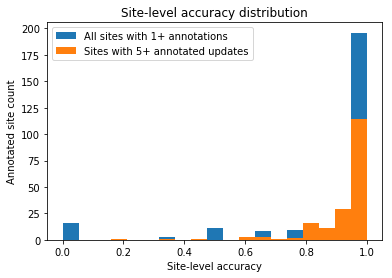

In [141]:
bins = np.linspace(0, 1, num=20)
plt.hist(site_df.accuracy, bins=bins, label='All sites with 1+ annotations')
plt.hist(site_df[site_df.total_count >= 5].accuracy, bins=bins, label='Sites with 5+ annotated updates')
plt.legend()
plt.title("Site-level accuracy distribution")
plt.xlabel("Site-level accuracy")
plt.ylabel("Annotated site count")
plt.show()

In [142]:
# 56.4% of sites are classified entirely correctly
np.sum(site_df.accuracy == 1) / len(site_df)

0.45901639344262296

In [143]:
# the percentage of sites that are classified at least 90% correctly,
# which suggests that our multiauthor heuristic will misclassify at the site-level at most (1 - this %) of the time
proportion_nearly_correct = len(site_df[site_df.accuracy >= 0.9]) / len(site_df)
proportion_nearly_correct, 1 - proportion_nearly_correct

(0.7311475409836066, 0.26885245901639343)

## Train the final sklearn model and apply it to all the unlabeled data

In [46]:
text_clf = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,2), min_df=3)),
     ('tfidf', TfidfTransformer()),
     ('clf', sklearn.linear_model.SGDClassifier(loss='hinge', alpha=0.001, tol=1e-4, max_iter=1000) ),
])

annotation_df['human_label'] = annotation_df['label'].map(lambda label: 'p' if label == 'p' else 'cg')

# eligible training data is all labeled data for the final model
train = annotation_df

cg_idx = train[train.human_label == 'cg'].index
cg_total = len(cg_idx)

p_idx = train[train.human_label == 'p'].sample(n=cg_total).index
p_total = len(p_idx)

train_idx = cg_idx.union(p_idx)
assert len(train_idx) == cg_total + p_total

# retrieve the subset of the eligible training data that will be used for estimation
train_subset = train.loc[train_idx]

# train the model and make predictions on the held-out test data
clf = text_clf.fit(train_subset.cleaned_body, train_subset.human_label)

train_preds = text_clf.predict(train_subset.cleaned_body)
acc = np.sum(train_preds == train_subset.human_label) / len(train_subset)
print(f"Train accuracy: {acc*100:.2f}%")

Train accuracy: 98.49%


#### Apply the trained model to the unlabled data

In [47]:
# if this flag is true,
# then predictions will only be made on not-yet-predicted rows in the journal_df
# this might be a good idea if the underlying sample changes, or if a specific subset of the predictions
# need to be thrown out and regenerated
# We load in the existing label dataframe, merge with the journal_df, and then leave all unlabeled rows blank
merge_existing_labels = True

In [48]:
# one time process
if merge_existing_labels:
    # read the journal metadata with author type info added
    s = datetime.now()
    author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
    journal_metadata_filepath = os.path.join(author_type_dir, "journal_metadata_with_author_type.df")
    journal_df_with_labels = pd.read_feather(journal_metadata_filepath)
    print(datetime.now() - s)
    len(journal_df_with_labels)

0:00:06.541071


In [49]:
journal_df['predicted_label'] = ""

In [50]:
if merge_existing_labels:
    original_length = len(journal_df)
    merged = pd.merge(journal_df, journal_df_with_labels[['site_id', 'journal_oid', 'predicted_label']], on=['site_id', 'journal_oid'], how='left')
    merged.loc[merged.predicted_label_y.isna(), 'predicted_label_y'] = ""
    merged['predicted_label'] = merged.predicted_label_y
    merged = merged.drop(columns=['predicted_label_x', 'predicted_label_y'])
    journal_df = merged
    assert original_length == len(journal_df)

In [51]:
Counter(journal_df.predicted_label).most_common()

[('cg', 11114668), ('p', 3570783), ('', 1164601)]

In [52]:
batch_size = 10000
num_batches = len(journal_df) // batch_size + 1
batch_size, num_batches

(10000, 1586)

In [53]:
# note that this only runs the classifier on rows of journal_df with predicted_label == ""
for batch_num in tqdm(range(num_batches)):
    journal_df_subset = journal_df.iloc[batch_num * batch_size:batch_num * batch_size + batch_size]
    journal_df_subset = journal_df_subset[journal_df_subset.predicted_label == ""]
    if len(journal_df_subset) == 0:
        continue
    journal_df_subset = add_body_text(journal_df_subset)
    preds = clf.predict(journal_df_subset.cleaned_body)
    journal_df.loc[journal_df_subset.index, 'predicted_label'] = preds
    if batch_num % 50 == 0:
        # keep writing a checkpoint file at regular intervals
        journal_metadata_filepath = os.path.join(general_working_dir, "journal_metadata_with_author_type.df.checkpoint")
        journal_df.reset_index(drop=True).to_feather(journal_metadata_filepath)

100%|██████████| 1586/1586 [1:18:35<00:00,  2.97s/it]  


In [54]:
s = datetime.now()
journal_metadata_filepath = os.path.join(general_working_dir, "journal_metadata_with_author_type.df")
journal_df.reset_index(drop=True).to_feather(journal_metadata_filepath)
print(datetime.now() - s)
print("Finished.")

0:00:07.188297
Finished.


## End of labeling all unlabeled data

### Now, some analysis on the result

In [8]:
# read the journal metadata with author type info added
s = datetime.now()
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
journal_metadata_filepath = os.path.join(author_type_dir, "journal_metadata_with_author_type.df")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:14.865886


15850052

In [9]:
journal_df = journal_df[journal_df.is_nontrivial]

In [10]:
journal_df.head(n=3)

,created_at,journal_oid,published_at,site_id,updated_at,user_id,site_index,is_nontrivial,predicted_label
0,1103856900000,51bdf3e56ca0048f4e00ced4,0,1,1103856900000,1,0,True,cg
1,1103943240000,51bdf3e56ca0048f4e00ced2,0,1,1103943240000,1,1,True,cg
2,1104288840000,51bdf3e56ca0048f4e00ced0,0,1,1104288840000,1,2,True,cg


In [11]:
Counter(journal_df.predicted_label).most_common()

[('cg', 11707863), ('p', 3890387)]

In [12]:
# what's the overall percentage that are patient-authored
np.sum(journal_df.predicted_label == 'p') / len(journal_df)

0.24941176093472023

In [13]:
user_proportions = journal_df.groupby(['user_id', 'site_id']).agg({'predicted_label': lambda group: np.sum(group == 'p') / len(group),
                                                                  'site_index': lambda group: len(group)})

In [14]:
user_proportions = user_proportions.rename(columns={'predicted_label': 'patient_proportion', 'site_index': 'site_total'})
user_proportions

patient_proportion  site_total
user_id  site_id                                
0        44                 0.000000          72
         102                0.369565          46
         308                0.166667          12
         664                0.000000           5
         670                0.028571         315
...                              ...         ...
40905335 1327430            0.000000           4
40906769 1327430            0.000000           1
40914864 1328992            0.000000           5
40933432 1330148            1.000000           4
40972477 1333192            1.000000           1

[414566 rows x 2 columns]

In [15]:
user_df = user_proportions.reset_index(level=user_proportions.index.names)
user_df.head()

,user_id,site_id,patient_proportion,site_total
0,0,44,0.000000,72
1,0,102,0.369565,46
2,0,308,0.166667,12
3,0,664,0.000000,5
4,0,670,0.028571,315


In [19]:
user_df = user_df[user_df.user_id.isin(valid_user_ids)]
len(user_df)

385374

In [24]:
# TODO probably split this into TWO designations: shared account/site, mixed site types

def compute_author_type(group):
    if len(group) == 1:
        site = group.iloc[0]
        patient_proportion = site.patient_proportion
        if patient_proportion >= 0.8:
            return 'p'
        elif patient_proportion >= 0.2:
            return 'shared'
        else:
            return 'cg'
    else:  # multiple sites on which this user has authored!
        is_shared = np.any((group.patient_proportion < 0.8)&(group.patient_proportion > 0.2))
        if is_shared:
            return 'shared'
        if np.sum(group.patient_proportion >= 0.8) / len(group) >= 0.5:
            return 'p'
        else:
            return 'cg'

In [21]:
author_type_series = user_df.groupby('user_id').apply(compute_author_type)

In [22]:
for key, value in Counter(author_type_series).most_common():
    print(key, value / len(author_type_series))

cg 0.6850708578840607
shared 0.18082766424264168
p 0.13410147787329754


In [27]:
author_type_df = author_type_series.rename("author_type").reset_index()
author_type_df.head()

,user_id,author_type
0,1,cg
1,2,cg
2,6,cg
3,12,cg
4,15,shared


In [28]:
# save the author type data
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
author_type_dataframe_filepath = os.path.join(author_type_dir, 'author_types.df')
author_type_df.to_feather(author_type_dataframe_filepath)
print("Finished.")

Finished.


In [29]:
# read the author type data
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
author_type_dataframe_filepath = os.path.join(author_type_dir, 'author_types.df')
author_type_df = pd.read_feather(author_type_dataframe_filepath)
len(author_type_df)

362345

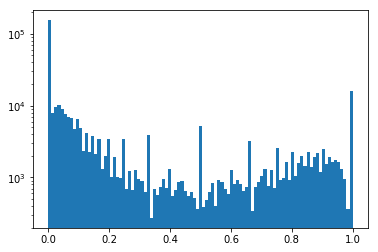

In [17]:
bins = np.linspace(0,1,num=100)
plt.hist(user_proportions.predicted_label, bins=bins, log=True)
plt.show()

In [24]:
threshold = 0.20
bin_vals, _ = np.histogram(user_proportions.predicted_label, bins=[0, threshold, 1 - threshold, 1])
bin_vals / len(user_proportions)

array([0.6883909 , 0.18148726, 0.13012185])

# Vowpal Wabbit

### Convert the data to VW format

In [ ]:
pos_lines = []
neg_lines = []
for i, annotation in annotation_df.iterrows():
    label_section = "-1"
    if annotation['label'] in ["p", "P"]:
        label_section = "+1"
    
    identifier = "sid%djoid%s" % (annotation['site_id'], annotation['journal_oid'])
    
    formatted_journal = label_section + " " + identifier + "|J " + annotation['cleaned_body']
    if label_section == "+1":
        pos_lines.append(formatted_journal)
    else:
        neg_lines.append(formatted_journal)

pos_lines[0], neg_lines[0]

In [28]:
# degree of class imbalance
pos_lines = np.array(pos_lines)
neg_lines = np.array(neg_lines)
len(pos_lines), len(neg_lines)

(5939, 994)

### Identify a balanced train/validation split

In [29]:
# undersample to create the training dataset
max_majority_class_pct = 2  # maximum number of majority class to include, as a percentage of the minority class
target_train_pos_lines = int(len(neg_lines) * max_majority_class_pct)
pos_included, pos_extra = train_test_split(pos_lines, train_size=target_train_pos_lines)
print("Pos included / left out:", len(pos_included), len(pos_extra))

holdout_percent = 0.2

train_lines, true_val_lines = train_test_split(np.concatenate((pos_included, neg_lines)), test_size=holdout_percent)
print("True validation:", len(true_val_lines))

#valid_lines = np.concatenate((true_val_lines, pos_extra))
valid_lines = true_val_lines

holdout_start_index = len(train_lines) + 1
holdout_start_index, len(train_lines), len(valid_lines)

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Pos included / left out: 1988 3951
True validation: 597


(2386, 2385, 597)

In [ ]:
train_lines[0]

In [ ]:
annotations[0]

In [32]:

#train_lines = []
#valid_lines = []

#holdout_percent = 0.2
#holdout_start_index = len(lines) - int(len(lines) * holdout_percent)

#train_lines = lines[:holdout_start_index]
#valid_lines = lines[holdout_start_index:]

#for i, annotation in enumerate(annotations):
#    annotation['in_training_data'] = i < holdout_start_index

#len(train_lines), len(valid_lines)

#### Write the train/test splits to a file

In [33]:
# write the formatted lines to a file (after another shuffle)
random.shuffle(train_lines)
random.shuffle(valid_lines)

vw_filename = "author_journal_text_only.txt"
vw_filepath = os.path.join(vw_working_dir, vw_filename)
with open(vw_filepath, 'w', encoding="utf-8") as outfile:
    for line in train_lines:
        outfile.write(line + "\n")
    for line in valid_lines:
        outfile.write(line + "\n")
holdout_after = len(train_lines)
print("Finished writing VW-formatted file.")

Finished writing VW-formatted file.


In [ ]:
!head -n 1 {vw_filepath}

In [35]:
#vw_filename = "author_journal_text_only.txt"
#vw_filepath = os.path.join(vw_working_dir, vw_filename)
#holdout_after = 1917

### Train the VW model on the training data

In [36]:
%%bash -s {vw_working_dir} {vw_filepath} {holdout_after}
holdout_after="${3}"
echo "Training on training set (holdout after ${holdout_after} lines)."
train_file=${2}
working_dir=${1}
model_file=${working_dir}
vw --binary -k -c -b 22 -d ${train_file} \
    -f ${working_dir}/patient_authored.model \
    --passes 20 \
    --holdout_after ${holdout_after} \
    --ngram 3 \
    --l2 0.000001 \
    --loss_function logistic

# Other options:
#    --skips 1 \
>&2 echo
>&2 echo

echo "Making predictions."
vw --binary \
   -t -i ${working_dir}/patient_authored.model \
   -p ${working_dir}/author_journal_text_only.pred \
   -d ${train_file} \
   -r ${working_dir}/author_journal_text_only.pred.raw

#echo "Predicting on test set."
#vw -t -i data/site_features_multiclass.model -d wd/site_features_multiclass_test.txt -p data/site_features_multiclass_test.pred
#echo
 
echo "Finished."

Training on training set (holdout after 2385 lines).
Making predictions.
Finished.


Generating 3-grams for all namespaces.
using l2 regularization = 1e-06
final_regressor = /home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type/vw/patient_authored.model
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type/vw/author_journal_text_only.txt.cache
Reading datafile = /home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type/vw/author_journal_text_only.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000  -1.0000      199
0.500000 0.000000            2            2.0   1.0000   1.0000     1684
0.500000 0.500000            4            4.0  -1.0000   1.0000       97
0.625000 0.750000            8            8.0   1.0000  -1.0

In [37]:
!head -n 5 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/author_journal_text_only.pred

1 sid912454joid5470dee0ca16b4c27bb0e9a5
1 sid999165joid54faf55eaf3d799c34ab808e
-1 sid837521joid54009962a589b4154824af37
1 sid1031202joid562b9247cb16b4f264752816
-1 sid867022joid55b61016ac7ee9534a13386c


In [38]:
!head -n 5 /home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/author_classification/vw/author_journal_text_only.pred.raw

7.854739 sid912454joid5470dee0ca16b4c27bb0e9a5
10.844439 sid999165joid54faf55eaf3d799c34ab808e
-8.962088 sid837521joid54009962a589b4154824af37
4.933350 sid1031202joid562b9247cb16b4f264752816
-3.771698 sid867022joid55b61016ac7ee9534a13386c


### Load the predictions made by VW on the training/validation data as a Pandas dataframe

In [39]:
def get_phase_predictions_with_weights(pred_filepath, raw_pred_filepath):
    
    with open(pred_filepath, 'r') as infile:
        pred_lines = infile.readlines()
    with open(raw_pred_filepath, 'r') as infile:
        raw_pred_lines = infile.readlines()
        
    if len(pred_lines) != len(raw_pred_lines):
        raise ValueError("Expected predicted and raw files to be the same length.")
    
    dtype_dict = {"site_id": int, 
                     "journal_oid": str,
                     "raw_prob": float,
                     "prob": float,
                     "is_patient": bool,
                     "is_patient_predicted": bool,
                     "in_training_data": bool}
    columns = list(dtype_dict.keys())
    dtype = [dtype_dict[col] for col in columns]
    pred_df = pd.DataFrame(index=range(len(pred_lines)), columns=columns)
    
    is_train_map = {}
    for train_line in train_lines:
        tokens = train_line[:70].strip().split(" ")
        label, journal_id = tokens[:2]
        journal_id = journal_id.split("|")[0]
        is_train_map[journal_id] = True
    
    is_pos_map = {}
    for pos_line in pos_lines:
        tokens = pos_line[:70].strip().split(" ")
        label, journal_id = tokens[:2]
        journal_id = journal_id.split("|")[0]
        is_pos_map[journal_id] = True
    
    index = 0
    for pred_line, raw_pred_line in zip(pred_lines, raw_pred_lines):
        prediction, journal_id = pred_line.strip().split(" ")
        site_id, journal_oid = journal_id.split("joid")
        site_id = int(site_id[3:])
        
        pred_df.iloc[index]["site_id"] = site_id
        pred_df.iloc[index]["journal_oid"] = journal_oid
        pred_df.iloc[index]["is_patient_predicted"] = prediction == "1"
        
        pred_df.iloc[index]["is_patient"] = journal_id in is_pos_map
        pred_df.iloc[index]["in_training_data"] = journal_id in is_train_map
        
        raw_prob, raw_journal_id = raw_pred_line.strip().split(" ")
        assert journal_id == raw_journal_id
        pred_df.iloc[index]["raw_prob"] = float(raw_prob)
        # if using a logistic loss function, we can recover the "probability" by applying the logistic function
        pred_df.iloc[index]["prob"] = 1 / (1 + np.exp(-1 * float(raw_prob) ))
        
        index += 1
    return pred_df

In [40]:
pred_df = get_phase_predictions_with_weights(os.path.join(vw_working_dir, "author_journal_text_only.pred"),
                                  os.path.join(vw_working_dir, "author_journal_text_only.pred.raw"))

print(pred_df.dtypes)  # datatypes just stay object for now...
pred_df.head()

site_id                 object
journal_oid             object
raw_prob                object
prob                    object
is_patient              object
is_patient_predicted    object
in_training_data        object
dtype: object


,site_id,journal_oid,raw_prob,prob,is_patient,is_patient_predicted,in_training_data
0,152591,51be20b86ca004df5c008be2,2.7519,0.940021,True,True,True
1,222767,51be30816ca0042711006307,15.2178,1,True,True,True
2,557731,51be59d06ca004c71b001abc,3.17108,0.959731,True,True,True
3,64076,51be07406ca004300d008b0e,-1.61925,0.165308,False,False,True
4,857627,52fad117a589b490782b58e4,-11.0897,1.52688e-05,False,False,True


In [41]:
# verify the contents of the merged data
np.sum(pred_df.is_patient) == len(pos_included), np.sum(pred_df.in_training_data) == len(train_lines)

(True, True)

In [42]:
np.sum(pred_df.is_patient) == len(pos_lines), len(pos_lines), np.sum(pred_df.is_patient)

(False, 5939, 1988)

In [43]:
def get_url(site_id, journal_oid, port=5000):
    url = "http://127.0.0.1:%d/siteId/%d#%s" % (port, site_id, journal_oid)
    return '<a href="{}">{}</a>'.format(url, url)

pd.set_option('display.max_colwidth', -1)  # allow the entirety of the url to show by removing column width limits

pred_df['annotation_url'] = [get_url(pred_df.iloc[i]['site_id'], pred_df.iloc[i]['journal_oid']) for i in range(len(pred_df))]
pred_df.head(n=1)

,site_id,journal_oid,raw_prob,prob,is_patient,is_patient_predicted,in_training_data,annotation_url
0,152591,51be20b86ca004df5c008be2,2.7519,0.940021,True,True,True,"<a href=""http://127.0.0.1:5000/siteId/152591#51be20b86ca004df5c008be2"">http://127.0.0.1:5000/siteId/152591#51be20b86ca004df5c008be2</a>"


### Pull out the training and validation data and analyze accuracy

In [44]:
train_df = pred_df[pred_df["in_training_data"] == True]
#print(len(train_df), len(train_lines))
assert len(train_df) == len(train_lines)

In [45]:
valid_df = pred_df[pred_df["in_training_data"] == False]
assert len(valid_df) == len(valid_lines)

In [46]:
# Train accuracy
np.sum(train_df["is_patient_predicted"] == train_df["is_patient"]) / len(train_df)

0.9953878406708595

In [47]:
# Validation accuracy
np.sum(valid_df["is_patient_predicted"] == valid_df["is_patient"]) / len(valid_df)

0.9514237855946399

In [48]:
Counter(valid_df["is_patient_predicted"]).most_common()

[(True, 412), (False, 185)]

In [49]:
Counter(valid_df["is_patient"]).most_common()

[(True, 399), (False, 198)]

In [50]:
y_true = [1 if b else 0 for b in valid_df["is_patient"]]
y_pred = [1 if b else 0 for b in valid_df["is_patient_predicted"]]

In [51]:
from sklearn.metrics import classification_report
classes=["Non-Patient", "Patient"]

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification report:
              precision    recall  f1-score   support

 Non-Patient       0.96      0.89      0.92       198
     Patient       0.95      0.98      0.96       399

   micro avg       0.95      0.95      0.95       597
   macro avg       0.95      0.94      0.94       597
weighted avg       0.95      0.95      0.95       597



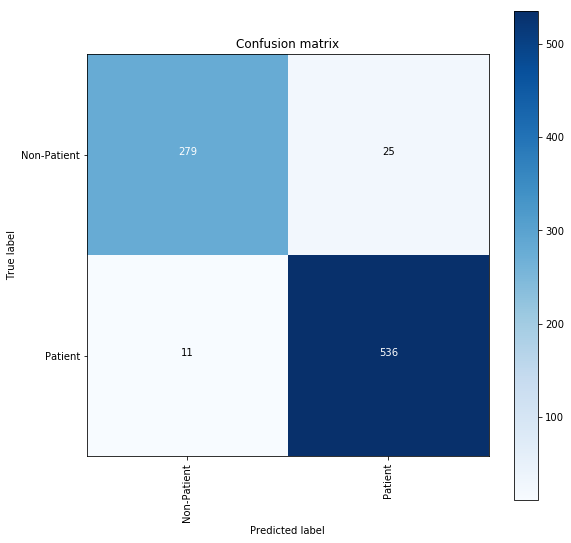

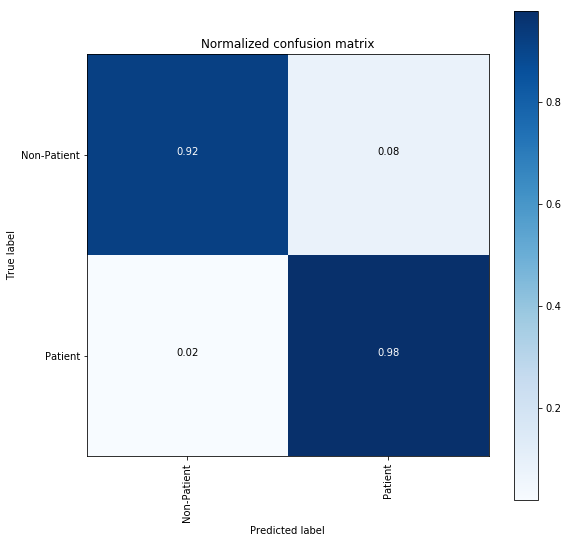

In [57]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# vis code borrowed from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, print_cm=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if print_cm:
        if normalize:
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

fig_size = (9,9)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=fig_size)
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure(figsize=fig_size)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

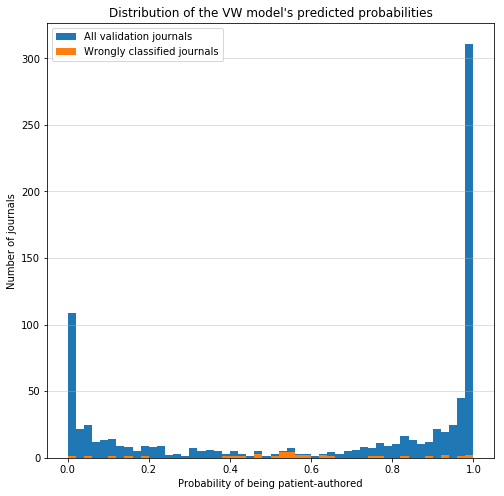

In [58]:
# Plot the distribution of the predicted probabilities
title = "Distribution of the VW model's predicted probabilities"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = np.array(valid_df['prob'], dtype=float)
patches = plt.hist(x, bins=50, range=(0,1), label="All validation journals")

# Plot the distribution of specifically the wrongly-classified journal entries
x2 = np.array(valid_df[valid_df["is_patient"] != valid_df["is_patient_predicted"]]['prob'], dtype=float)
plt.hist(x2, bins=50, range=(0,1), label="Wrongly classified journals")
ax.set_title(title)
ax.set_xlabel("Probability of being patient-authored")
ax.set_ylabel("Number of journals")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

In [59]:
# Within the errors, show the least-confident journal posts
errors = valid_df[valid_df["is_patient"] != valid_df["is_patient_predicted"]]
inds = np.argsort(np.abs(errors['prob'] - 0.5))

# Show the n least-confident results that were wrongly classified
n = 10
toughest_n = errors.iloc[inds[:n]]

HTML(toughest_n.to_html(escape=False))

,site_id,journal_oid,raw_prob,prob,is_patient,is_patient_predicted,in_training_data,annotation_url
3503,845819,52a5e463ca16b44a10ffcabc,0.080036,0.519998,False,True,False,http://127.0.0.1:5000/siteId/845819#52a5e463ca16b44a10ffcabc
3811,146470,51be1f0d6ca0047d5700d7b0,-0.098129,0.475487,True,False,False,http://127.0.0.1:5000/siteId/146470#51be1f0d6ca0047d5700d7b0
4067,829111,5245f47bac7ee969526702ec,-0.103169,0.474231,True,False,False,http://127.0.0.1:5000/siteId/829111#5245f47bac7ee969526702ec
3518,1065713,56452582af3d799d4ff925d2,0.10584,0.526435,False,True,False,http://127.0.0.1:5000/siteId/1065713#56452582af3d799d4ff925d2
3818,594495,51be5dce6ca0040029002861,0.129424,0.532311,False,True,False,http://127.0.0.1:5000/siteId/594495#51be5dce6ca0040029002861
3648,661255,51be8a386ca004dd320019f2,0.133348,0.533288,False,True,False,http://127.0.0.1:5000/siteId/661255#51be8a386ca004dd320019f2
3994,864283,53176be84db9210b790480ee,-0.14482,0.463858,True,False,False,http://127.0.0.1:5000/siteId/864283#53176be84db9210b790480ee
3762,898453,54595c4df02065f405bed2de,0.153013,0.538179,False,True,False,http://127.0.0.1:5000/siteId/898453#54595c4df02065f405bed2de
3595,840297,53588534ac7ee9aa0f6adb2d,0.16442,0.541013,False,True,False,http://127.0.0.1:5000/siteId/840297#53588534ac7ee9aa0f6adb2d
3477,388128,51be475a6ca004d65b003c41,0.19572,0.548774,False,True,False,http://127.0.0.1:5000/siteId/388128#51be475a6ca004d65b003c41


### Save the predictions of the model on the training/validation data

In [60]:
# insert predictions into annotation web client's database
def insert_author_predictions(predictions, commit=True):
    prediction_type = 'journal_author_type'
    try:
        db = get_annotation_db()
        
        for prediction in predictions:
            site_id = prediction['site_id']
            journal_oid = prediction['journal_oid']
            data = prediction['data']
            probability = prediction['probability']
        
            db.execute(
                """INSERT INTO journalPrediction 
                (site_id, journal_oid, prediction_type, data, probability) 
                VALUES (?, ?, ?, ?, ?)""",
                (site_id, journal_oid, prediction_type, data, probability)
            )
        
        
        if commit:
            db.commit()
    finally:
        db.close()

In [62]:
skip_prediction_insertion = False
if not skip_prediction_insertion:
    predictions = [{'site_id': pred_df.iloc[i]['site_id'],
                    'journal_oid': pred_df.iloc[i]['journal_oid'],
                    'data': "Patient" if pred_df.iloc[i]['is_patient_predicted'] else "Non-patient",
                    'probability': pred_df.iloc[i]['prob']}
                   for i in range(len(pred_df))]
    print(predictions[0])

{'site_id': 660931, 'journal_oid': '51be8a326ca004c83200173b', 'data': 'Patient', 'probability': 0.9764946909309304}


In [63]:
if not skip_prediction_insertion:
    insert_author_predictions(predictions)

### Apply the model to unlabeled data

First, we'll create a file in VW format from a set of unlabeled sites.

Then, we'll apply the model to the file to get predictions.

Finally, we'll load in the predictions and analyze the highest and lowest confidence journals to see if there are clear error patterns or if there is a clear bias in the model.

In [64]:
candidate_site_working_dir = "/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/identify_candidate_sites"
valid_sites_filename = os.path.join(candidate_site_working_dir, "valid_classification_sites.txt")

In [65]:
with open(valid_sites_filename, 'r') as infile:
    candidate_site_ids = [int(line.strip()) for line in infile]
len(candidate_site_ids)

58363

In [66]:
# randomly select a subset of n sites to predict the labels for
random.shuffle(candidate_site_ids)

n = 1000
candidate_subset = candidate_site_ids[:n]

candidate_subset[:5]

[382262, 158520, 1060990, 129632, 291508]

#### Format the selected sites in VW format

In [127]:
unlabeled_vw_test_filepath = os.path.join(vw_working_dir, "unlabeled_candidate_sites.txt")

# only create the file if it doesn't exist
overwrite_unlabeled_file = True

lines_written = 0
if not os.path.exists(unlabeled_vw_test_filepath) or overwrite_unlabeled_file:
    with open(unlabeled_vw_test_filepath, 'w', encoding="utf-8") as outfile:
        for site_id in tqdm(candidate_subset):
            body_list = get_journal_texts(site_id)
            for body in body_list:
                journal_oid = body['journal_oid']
                body_text = body['body']
                if len(body_text) < 50:
                    continue
                cleaned_body = get_cleaned_text(body_text)

                identifier = "sid%djoid%s" % (site_id, journal_oid)
                formatted_journal = identifier + "|J " + cleaned_body

                outfile.write(formatted_journal + "\n")
                lines_written += 1

lines_written

100%|██████████| 1000/1000 [05:44<00:00,  4.43it/s]


54809

In [ ]:
!head -n 1 {unlabeled_vw_test_filepath}

#### Apply the VW model to the file

In [129]:
%%bash -s {vw_working_dir} {unlabeled_vw_test_filepath}
working_dir=${1}
unlabeled_vw_test_filepath=${2}

echo "Making predictions on test file."
vw --binary \
   -t -i ${working_dir}/patient_authored.model \
   -p ${working_dir}/unlabeled_text_only.pred \
   -r ${working_dir}/unlabeled_text_only.pred.raw \
   -d ${unlabeled_vw_test_filepath}
 
echo "Finished."

Making predictions on test file.
Finished.


Generating 3-grams for all namespaces.
only testing
predictions = /home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type/vw/unlabeled_text_only.pred
raw predictions = /home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type/vw/unlabeled_text_only.pred.raw
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type/vw/unlabeled_candidate_sites.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   1.0000     1510
    n.a.     n.a.            2            2.0  unknown   1.0000      403
    n.a.     n.a.            4            4.0  unknown   1.0000      409
    n.a.     n.a.            8            8.0  unknown   1.0000     1651
    n.a.     n.a.         

In [130]:
raw_predictions_filepath = os.path.join(vw_working_dir, "unlabeled_text_only.pred.raw")
assert os.path.exists(raw_predictions_filepath)

In [131]:
!head {raw_predictions_filepath}

4.509168 sid881145joid535c85e9e9cb6a301bdc936b
0.897970 sid881145joid53606313ac7ee9a842611f95
5.440414 sid881145joid5361d6c7a689b4d574f3fc68
1.093930 sid881145joid53718837ca16b4b04da2e426
7.313563 sid881145joid537ec931ab28b946603fa56d
1.226371 sid881145joid538558b48b5cd3bc0db647d9
1.407135 sid881145joid5397c759cb16b4e94bd7571a
4.706953 sid881145joid53ba1f28ca16b4ef36c97952
5.305619 sid881145joid53dfcf14ac7ee99504155c91
0.465066 sid881145joid53ebcbb4ac7ee96024b88963


#### Load the predictions into Python

In [132]:
def get_author_predictions(raw_predictions_filepath):
    
    with open(raw_predictions_filepath, 'r') as infile:
        pred_lines = infile.readlines()
    
    dtype_dict = {"site_id": int, 
                     "journal_oid": str,
                     "prob": float,
                     "is_patient": bool}
    columns = list(dtype_dict.keys())
    dtype = [dtype_dict[col] for col in columns]
    pred_df = pd.DataFrame(index=range(len(pred_lines)), columns=columns)
    
    site_id_list = []
    journal_oid_list = []
    prob_list = []
    is_patient_list = []
    url_list = []
    index = 0
    for pred_line in tqdm(pred_lines):
        raw_prob, journal_id = pred_line.strip().split(" ")
        site_id, journal_oid = journal_id.split("joid")
        site_id = int(site_id[3:])
        
        # probability is computed assuming a logistic loss function
        # if we change the model to use a different loss, this won't work anymore!
        prob = 1 / (1 + np.exp(-1 * float(raw_prob) ))
        assert prob >= 0 and prob <= 1
        is_patient = prob >= 0.5
        
        url = get_url(site_id, journal_oid)
        
        site_id_list.append(site_id)
        journal_oid_list.append(journal_oid)
        prob_list.append(prob)
        is_patient_list.append(is_patient)
        url_list.append(url)
        
        #pred_df.iloc[index]["site_id"] = site_id
        #pred_df.iloc[index]["journal_oid"] = journal_oid
        #pred_df.iloc[index]["is_patient"] = is_patient
        #pred_df.iloc[index]["raw_prob"] = float(raw_prob)
        #pred_df.iloc[index]["prob"] = prob
        
        index += 1
    
    pred_df['site_id'] = site_id_list
    pred_df['journal_oid'] = journal_oid_list
    pred_df['prob'] = prob_list
    pred_df['is_patient'] = is_patient_list
    pred_df['annotation_url'] = url_list
    return pred_df

In [135]:
unlabeled_df = get_author_predictions(raw_predictions_filepath)
len(unlabeled_df)

100%|██████████| 54809/54809 [00:00<00:00, 152323.43it/s]


54809

In [136]:
unlabeled_df.head()

,site_id,journal_oid,prob,is_patient,annotation_url
0,881145,535c85e9e9cb6a301bdc936b,0.989112,True,"<a href=""http://127.0.0.1:5000/siteId/881145#535c85e9e9cb6a301bdc936b"">http://127.0.0.1:5000/siteId/881145#535c85e9e9cb6a301bdc936b</a>"
1,881145,53606313ac7ee9a842611f95,0.710532,True,"<a href=""http://127.0.0.1:5000/siteId/881145#53606313ac7ee9a842611f95"">http://127.0.0.1:5000/siteId/881145#53606313ac7ee9a842611f95</a>"
2,881145,5361d6c7a689b4d574f3fc68,0.995681,True,"<a href=""http://127.0.0.1:5000/siteId/881145#5361d6c7a689b4d574f3fc68"">http://127.0.0.1:5000/siteId/881145#5361d6c7a689b4d574f3fc68</a>"
3,881145,53718837ca16b4b04da2e426,0.749121,True,"<a href=""http://127.0.0.1:5000/siteId/881145#53718837ca16b4b04da2e426"">http://127.0.0.1:5000/siteId/881145#53718837ca16b4b04da2e426</a>"
4,881145,537ec931ab28b946603fa56d,0.999334,True,"<a href=""http://127.0.0.1:5000/siteId/881145#537ec931ab28b946603fa56d"">http://127.0.0.1:5000/siteId/881145#537ec931ab28b946603fa56d</a>"


#### Write the assigned predictions to the annotation database

In [140]:
# we have to do some tedious nonsense here to avoid dealing with how slow pandas indexing is
if not skip_prediction_insertion:
    site_id_list = unlabeled_df['site_id'].tolist()
    journal_oid_list = unlabeled_df['journal_oid'].tolist()
    prob_list = unlabeled_df['prob'].tolist()
    is_patient_list = unlabeled_df['is_patient'].tolist()
    predictions = [{'site_id': site_id, 
                    'journal_oid': journal_oid,
                    'data': "Patient" if is_patient else "Non-patient",
                    'probability': prob} 
                   for site_id, journal_oid, is_patient, prob
                   in tqdm(zip(site_id_list, journal_oid_list, is_patient_list, prob_list))]
    del site_id_list, journal_oid_list, is_patient_list, prob_list
    print(predictions[0], len(predictions))

54809it [00:00, 1208143.83it/s]

{'site_id': 881145, 'journal_oid': '535c85e9e9cb6a301bdc936b', 'data': 'Patient', 'probability': 0.9891122336346914} 54809


In [141]:
len(predictions)

54809

In [142]:
%%time
if not skip_prediction_insertion:
    insert_author_predictions(predictions)

CPU times: user 721 ms, sys: 468 ms, total: 1.19 s
Wall time: 11.1 s


In [143]:
# these are redundant with the df, and may take up quite a lot of memory, so delete them
if not skip_prediction_insertion:
    del predictions

#### Analyze the predictions produced by the model on the unlabeled sites

We look at the general distribution of the probabilities and look at the journals about which the classifier is least certain.

We then look at the distribution of patient posts within a site.

In [144]:
Counter(unlabeled_df['is_patient']).most_common()

[(False, 29214), (True, 25595)]

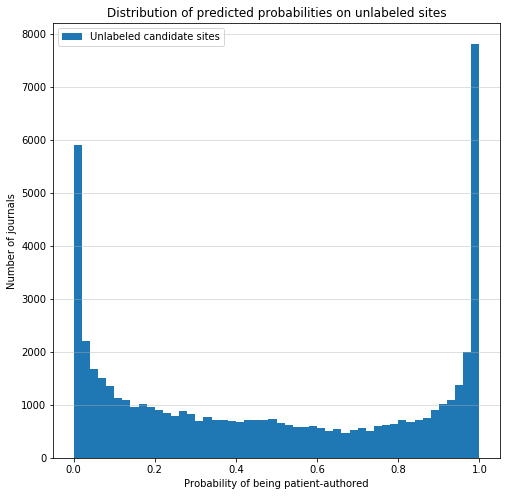

In [145]:
# Plot the distribution of unlabeled journal predicted probabilities
title = "Distribution of predicted probabilities on unlabeled sites"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = np.array(unlabeled_df['prob'], dtype=float)
patches = plt.hist(x, bins=50, range=(0,1), label="Unlabeled candidate sites")

ax.set_title(title)
ax.set_xlabel("Probability of being patient-authored")
ax.set_ylabel("Number of journals")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

In [55]:
# Within the errors, compute the least-confident journal posts (those with probability closest to 0.5)
inds = np.argsort(np.abs(unlabeled_df['prob'] - 0.5))

In [56]:
# Show the n least-confident results in a dataframe
n = 16
toughest_n = unlabeled_df.iloc[inds[:n]]

HTML(toughest_n.to_html(escape=False))

,site_id,journal_oid,prob,is_patient,annotation_url
1100408,190877,51be29e96ca004487a007bd0,0.500000,True,http://127.0.0.1:5000/siteId/190877#51be29e96ca004487a007bd0
896765,180789,51bf38686ca004e77811587c,0.500000,True,http://127.0.0.1:5000/siteId/180789#51bf38686ca004e77811587c
1514884,211597,51be2f106ca004200c01278c,0.500000,True,http://127.0.0.1:5000/siteId/211597#51be2f106ca004200c01278c
2809056,907882,544446e14db921cd51426502,0.500000,False,http://127.0.0.1:5000/siteId/907882#544446e14db921cd51426502
1286027,200024,51be2c296ca004a90200a919,0.500001,True,http://127.0.0.1:5000/siteId/200024#51be2c296ca004a90200a919
2303548,573549,51be5b866ca0045e21003353,0.499999,False,http://127.0.0.1:5000/siteId/573549#51be5b866ca0045e21003353
2513351,623145,51be87136ca0040e28001748,0.500001,True,http://127.0.0.1:5000/siteId/623145#51be87136ca0040e28001748
843965,176398,51be26bf6ca004007000e751,0.499998,False,http://127.0.0.1:5000/siteId/176398#51be26bf6ca004007000e751
848549,176398,51bf38736ca004e77811eb48,0.499998,False,http://127.0.0.1:5000/siteId/176398#51bf38736ca004e77811eb48
2842933,910321,54cae85bab28b9e44fb994e3,0.499998,False,http://127.0.0.1:5000/siteId/910321#54cae85bab28b9e44fb994e3


In [57]:
patient_proportions_dict = {}
total_patient_journals = 0
for site_id, group in unlabeled_df.groupby(by="site_id"):
    patient_journals = np.count_nonzero(group['is_patient'])
    total_patient_journals += patient_journals
    
    num_journals = len(group)
    
    patient_proportion = patient_journals / num_journals
    patient_proportions_dict[site_id] = patient_proportion
print("Identified %d total journals as patient-authored." % total_patient_journals)
len(patient_proportions_dict)

Identified 1260096 total journals as patient-authored.


58462

In [69]:
# Write out the site proportions data to a CSV file
site_proportions_filepath = os.path.join(general_working_dir, "site_proportions.csv")
with open(site_proportions_filepath, 'w') as outfile:
    outfile.write("site_id,proportion_patient_authored\n")
    for site_id in patient_proportions_dict:
        proportion_patient_authored = patient_proportions_dict[site_id]
        outfile.write("{},{}\n".format(site_id, proportion_patient_authored))
print("Finished.")

Finished.


In [58]:
Counter(["Mostly patient" if p > 0.5 else "Mostly non-patient" for p in patient_proportions_dict.values()]).most_common()

[('Mostly non-patient', 34873), ('Mostly patient', 23589)]

In [59]:
# percent that are mostly patient-authored
np.sum([1 if p > 0.5 else 0 for p in patient_proportions_dict.values()]) / len(patient_proportions_dict)

0.40349286716157506

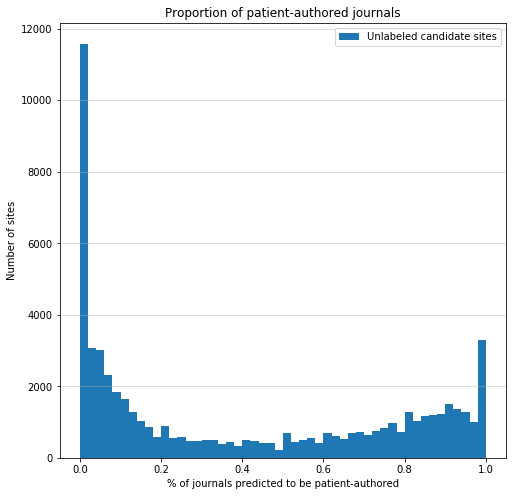

In [60]:
# Plot the distribution of unlabeled journal predicted probabilities
title = "Proportion of patient-authored journals"
fig, ax = pl.subplots(num=title, figsize=(8,8))
x = patient_proportions_dict.values()
patches = plt.hist(x, bins=50, range=(0,1), label="Unlabeled candidate sites")

ax.set_title(title)
ax.set_xlabel("% of journals predicted to be patient-authored")
ax.set_ylabel("Number of sites")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

In [61]:
# look at the distribution over time (by bucketing by percentile journals complete on the site?)

def get_journal_metadata_db():
    db_filepath="/home/srivbane/shared/caringbridge/data/projects/qual-health-journeys/extract_site_features/journal_metadata.db"
    db = sqlite3.connect(
            db_filepath,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
    db.row_factory = sqlite3.Row
    return db

def get_journal_times(site_id):
    try:
        db = get_journal_metadata_db()
        cursor = db.execute("""SELECT journal_oid, site_index, created_at
                                    FROM journalMetadata
                                    WHERE site_id = ? 
                                    GROUP BY journal_oid
                                    ORDER BY id DESC""",
                                (site_id,))
        
        times = []
        results = cursor.fetchall()
        if results is None:
            return []
        for result in results:
            d = {key: result[key] for key in result.keys()}
            times.append(d)
        times.sort(key=lambda d: d['created_at'])
        
        journal_oid_dict = {}
        for time_dict in times:
            journal_oid_dict[time_dict['journal_oid']] = time_dict
        return journal_oid_dict
    finally:
        db.close()

buckets = 20
percentile_gap = 1 / buckets
print("%d buckets will each capture %.2f%% of a site's journals." % (buckets, percentile_gap * 100))

total_bucket_counts = [0 for i in range(buckets)]
is_patient_bucket_counts = [0 for i in range(buckets)]

for site_id, group in tqdm(unlabeled_df.groupby(by="site_id")):
    if len(group) < 20:
        continue  # only compute percentiles for sites with at least X journals
    
    journal_times = get_journal_times(site_id)
    num_journals = len(journal_times)
    assert num_journals >= len(group)
    
    journal_oid_list = group['journal_oid']
    is_patient_list = group['is_patient'].tolist()
    
    for i, journal_oid in enumerate(journal_oid_list):
        site_index = journal_times[journal_oid]['site_index']
        created_at = journal_times[journal_oid]['created_at']
        
        percent_through_site = site_index / num_journals
        assert percent_through_site < 1
        
        bucket_right_boundary = percentile_gap
        bucket = 0
        while percent_through_site > bucket_right_boundary:
            bucket += 1
            bucket_right_boundary += percentile_gap
        
        #print(site_index, percent_through_site, bucket)
        if bucket_right_boundary >= 1:  # should be in the last bucket
            bucket = buckets - 1
            
        total_bucket_counts[bucket] += 1
        if is_patient_list[i]:
            is_patient_bucket_counts[bucket] += 1
np.mean(total_bucket_counts), np.mean(is_patient_bucket_counts)

20 buckets will each capture 5.00% of a site's journals.


100%|██████████| 58462/58462 [02:33<00:00, 381.46it/s]


(141703.45, 58771.75)

In [62]:
is_patient_bucket_counts

[64512,
 56772,
 56908,
 59264,
 59222,
 57709,
 59203,
 57269,
 61142,
 56583,
 63835,
 62331,
 58639,
 60554,
 60884,
 58707,
 57769,
 58519,
 56602,
 49011]

In [63]:
bucket_proportions = [patient / total for patient, total in zip(is_patient_bucket_counts, total_bucket_counts)]
bucket_proportions

[0.39526747584415267,
 0.40064925899788284,
 0.4048950551405194,
 0.4097515107097916,
 0.4148186543014443,
 0.41601966593856554,
 0.4187745805392864,
 0.4208078299398206,
 0.4225665551654549,
 0.424762219336241,
 0.4229668305482302,
 0.4236860708556513,
 0.42322127112894614,
 0.4226063774103722,
 0.4204492876725573,
 0.4175462304409673,
 0.41688496316021156,
 0.41121081590061065,
 0.40604017216642757,
 0.4032001974414874]

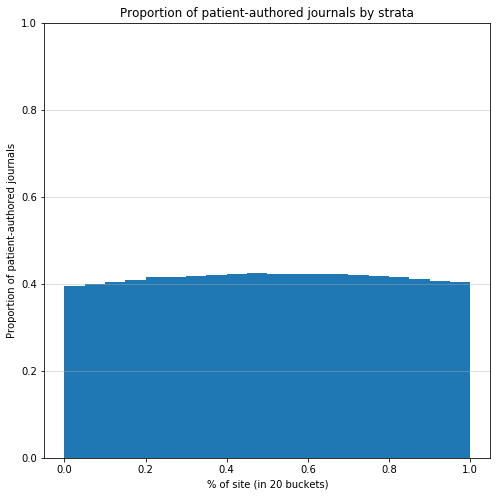

In [64]:
title = "Proportion of patient-authored journals by strata"
fig, ax = pl.subplots(num=title, figsize=(8,8))

x = np.arange(0, 1, percentile_gap)
y = bucket_proportions
plt.bar(x, y, percentile_gap, align='edge')

ax.set_title(title)
ax.set_xlabel("%% of site (in %d buckets)" % buckets)
ax.set_ylabel("Proportion of patient-authored journals")

#ax.set_xticks([i for i in range(0, 108, 4)])
#ax.set_xticklabels([str(i) if i != 104 else "+" for i in range(0, 108, 4)])

#ax.set_yticks([i for i in range(0, 430, 10)])

ax.set_ylim((0, 1))

ax.grid(axis="y", alpha=0.5)
plt.show()

## Apply model to all journals via streaming

Everything below here was moved to a separate script: `predict_author_type.py`

In [16]:
from subprocess import Popen, PIPE

In [24]:
import sys
sys.path.append("/home/srivbane/levon003/repos/qual-health-journeys/annotation_data")
import journal as journal_utils

In [58]:
from importlib import reload
journal_utils = reload(journal_utils)

In [59]:
vw_streaming_command = f"vw --quiet -i {vw_working_dir}/patient_authored.model -t -p /dev/stdout"
vw_streaming_command

'vw --quiet -i /home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type/vw/patient_authored.model -t -p /dev/stdout'

In [ ]:
res = list(journal_utils.iter_journal_texts(limit=10))
len(res), res[0]

In [74]:
def get_preds(results):
    # expects results of the form "0.564 sid912454joid5470dee0ca16b4c27bb0e9a5\n"
    preds = []
    try:
        for result in results:
            if result.strip() == '':
                continue
            pred, key = result.strip().split(" ")
            pred = float(pred)
            siteId, journalOid = key.split("joid")
            siteId = int(siteId[3:])
            pred_dict = {'author_type_raw_prediction': pred,
                         'site_id': siteId,
                         'journal_oid': journalOid}
            preds.append(pred_dict)
    except Exception as ex:
        print(ex)
        print("Potentially erroneous result:", result)
    return preds


def get_vw_format(journal):
    text = journal_utils.get_journal_text_representation(journal)
    if text is None:
        return None
    cleaned_text = get_cleaned_text(text, strip_tags=False)
    identifier = "sid%djoid%s" % (journal['site_id'], journal['journal_oid'])
    return " " + identifier + "|J " + cleaned_text + "\n"


def process_batch(batch_lines, vw_proc):
    for line in batch_lines:
        #print(line)
        vw_proc.stdin.write(line)
        vw_proc.stdin.flush()
    results = []
    for i in range(len(batch_lines)):
        result = vw_proc.stdout.readline()
        #print(result)
        if result == '':
            raise ValueError("Reached end of stdout, which is a surprise given that # inputs should == # outputs.")
        results.append(result)
    preds = get_preds(results)
    return preds


def write_preds(fd, preds):
    for p in preds:
        line = "{},{},{}\n".format(p['site_id'], p['journal_oid'], p['author_type_raw_prediction'])
        fd.write(line)

def stream_journals(preds_filepath):
    vw_proc = Popen(vw_streaming_command, 
                    shell=True, encoding='utf-8',
                    stdout=PIPE, stdin=PIPE, stderr=None)
    try:
        
        batch_size = 100
        batch_lines = []
        journal_iter = journal_utils.iter_journal_texts(limit=10000)
        estimated_length = 15327592  # total number of journals
        report_frequency = 1000
        with open(preds_filepath, 'w') as outfile:
            for i, journal in enumerate(journal_iter):
                if i % report_frequency == 0:
                    print(i, "%.2f" % (i / estimated_length * 100))
                line = get_vw_format(journal)
                if line is None:
                    continue
                batch_lines.append(line)
                if len(batch_lines) == batch_size:
                    batch_preds = process_batch(batch_lines, vw_proc)
                    write_preds(outfile, batch_preds)
                    batch_lines = []
            if len(batch_lines) > 0:
                batch_preds = process_batch(batch_lines, vw_proc)
                write_preds(outfile, batch_preds)
    finally:
        vw_proc.stdin.close()
        vw_proc.stdout.close()


In [75]:
preds_filepath = os.path.join(vw_working_dir, "all_journal_preds.csv")
stream_journals(preds_filepath)

0 0.00
1000 0.01
2000 0.01
3000 0.02
4000 0.03
5000 0.03
6000 0.04
7000 0.05
8000 0.05
9000 0.06


In [ ]:
# initial time estimate
# 100000 journals processed in 314 seconds
# Suggesting a full run will take 13.36 hours

In [70]:
!tail {preds_filepath}

10651,51bdf6696ca004715600bf1d,-2.984672
76,51bdf3e56ca0048f4e00d59e,-0.636211
10672,51bdf6696ca004715600bf1f,-2.474923
50,51bdf3e56ca0048f4e00d5a0,-4.265691
10651,51bdf6696ca004715600bf21,-3.272066
1,51bdf3e56ca0048f4e00d5a2,-1.020766
10664,51bdf6696ca004715600bf23,7.697199
50,51bdf3e56ca0048f4e00d5a4,-3.765584
10672,51bdf6696ca004715600bf25,-0.552072
18,51bdf3e56ca0048f4e00d5a6,-1.356195


In [71]:
!wc -l {preds_filepath}

9621 /home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type/vw/all_journal_preds.csv
